# TPM034A Machine Learning for socio-technical systems
## `Assignment 04: Explainable AI and appliance usage prediction`

**Delft University of Technology**<br>
**Q2 2023**<br>
**Instructor:** Giacomo Marangoni <br>
**TAs:**  Francisco Garrido-Valenzuela & Lucas Spierenburg <br>

## `Instructions`

**Assignments aim to:**<br>
* Examine your understanding of the key concepts and techniques.
* Examine your the applied ML skills.

**Assignments:**<br>
* Are graded and must be submitted (see the submission instruction below).

### `Workspace set-up`

**Option 1: Local environment**<br>
Uncomment the following cell if you are running this notebook on your local environment. This will install all dependencies on your Python version.

In [ ]:
#!pip install -r requirements_lab04.txt

**Option 2: Google Colab**<br>
Uncomment the following cells code lines if you are running this notebook on Colab

In [2]:
!git clone https://github.com/TPM034A/Q2_2023
!pip install -r Q2_2023/requirements_lab04.txt
!mv "/content/Q2_2023/Assigments/assignment_04/data" /content/data

Cloning into 'Q2_2023'...
remote: Enumerating objects: 275, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 275 (delta 48), reused 89 (delta 36), pack-reused 159
Receiving objects: 100% (275/275), 96.69 MiB | 10.42 MiB/s, done.
Resolving deltas: 100% (94/94), done.
Updating files: 100% (77/77), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 1.2 MB/s eta 0:00:00


In [3]:
# Basic libraries
import pandas as pd
from os import getcwd
import random
import numpy as np

# ML tools
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
# Models
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

# Visualization libraries
from matplotlib import pyplot as plt
import seaborn as sns

# Other libraries
from pathlib import Path
import pickle

# Show all columns
pd.set_option('display.max_columns', None)

# `Application: Explainable AI and appliance usage prediction` <br>

#### **Introduction**

In this notebook you are going to train and explain a Random Forest Classifier model to predict the probability of using a given appliance in the next 24 hours.

#### **Data**

1. `data/devices.pkl`: A pickle file with a pandas.DataFrame of Wh hourly energy consumption by appliance within a household of the REFIT dataset, over a period of about two years.
2. `data/devices.pkl`: A pickle file with a pandas.DataFrame of normalized weather variables: `dwpt` is Dew Point (related to moisture), `rhum` is relative humidity, `temp` is temperature, `wdir` is wind direction, `wspd` is wind speed.
3. `data/price.pkl`: A pickle file with a pandas.Series with electricity day-ahead prices in GBP/MWh.


### **Tasks and grading**

Your assignment is divided into 5 subtasks: (1) Data preparation, (2) Data exploration, (3) Model training, (4) Model explanation and (5) Reflections. In total, 10 points can be earned in this assignment. The weight per subtask is indicated below.

1. **Data preparation** [1.0 pnt]<br>

2. **Data exploration** [2.0 pnt]<br>
    
3. **Model training** [2.0 pnt]<br>
    
4. **Model explanation** [3.0 pnt]<br>

5. **Reflections** [2.0 pnt]<br>

### **Submission**
- The deadline for this assignment is **Monday 18/12/2023 23:59**
- Use **Python 3.10 or above**
- You have to submit your work in zip file with the ipynb **(fully executed)**

### Data preparation

In [4]:
# Load 'data/devices.pkl', 'data/weather.pkl' and 'data/price.pkl'.
# Weather is the same as in the lab session.
# Devices contains Wh consumed by given devices at each timestamp.
# Price contains electricity prices for each timestamp.

devices = pd.read_pickle('data/devices.pkl')
weather = pd.read_pickle('data/weather.pkl')
elect_price = pd.read_pickle('data/price.pkl')

In [5]:
print(devices.shape)
devices.head()

(14752, 9)


,Toaster,Fridge-Freezer,Freezer,Tumble Dryer,Dishwasher,Washing Machine,Television,Microwave,Kettle
Time,,,,,,,,,
2013-09-25 19:00:00,0.0,28.381963,37.084881,0.0,0.0,0.0,144.262599,0.0,0.0
2013-09-25 20:00:00,0.0,50.966044,44.848896,0.0,0.0,0.0,143.933786,0.0,0.0
2013-09-25 21:00:00,0.0,31.829103,36.810491,0.0,0.0,0.0,68.949239,0.0,0.0
2013-09-25 22:00:00,0.0,34.850258,36.289157,0.0,0.0,0.0,0.000000,0.0,0.0
2013-09-25 23:00:00,0.0,50.380546,36.912969,0.0,0.0,0.0,0.000000,0.0,0.0


In [6]:
print(weather.shape)
weather.head()

(14752, 5)


,dwpt,rhum,temp,wdir,wspd
Time,,,,,
2013-09-25 19:00:00,0.62500,0.774074,0.833333,0.114286,0.123684
2013-09-25 20:00:00,0.62500,0.733333,0.750000,0.085714,0.100000
2013-09-25 21:00:00,0.59375,0.737037,0.833333,0.057143,0.171053
2013-09-25 22:00:00,0.59375,0.737037,0.833333,0.171429,0.242105
2013-09-25 23:00:00,0.53125,0.703704,0.916667,0.142857,0.269737


In [7]:
print(elect_price.shape)
elect_price.head()

(26280,)


Time
2013-01-01 00:00:00    0.0
2013-01-01 01:00:00    0.0
2013-01-01 02:00:00    0.0
2013-01-01 03:00:00    0.0
2013-01-01 04:00:00    0.0
dtype: float64

In [8]:
# Add a colum "Load" to devices as the sum of all appliances consumption
devices['Load'] = devices.sum(axis=1, numeric_only=True)
devices.head()

,Toaster,Fridge-Freezer,Freezer,Tumble Dryer,Dishwasher,Washing Machine,Television,Microwave,Kettle,Load
Time,,,,,,,,,,
2013-09-25 19:00:00,0.0,28.381963,37.084881,0.0,0.0,0.0,144.262599,0.0,0.0,209.729443
2013-09-25 20:00:00,0.0,50.966044,44.848896,0.0,0.0,0.0,143.933786,0.0,0.0,239.748727
2013-09-25 21:00:00,0.0,31.829103,36.810491,0.0,0.0,0.0,68.949239,0.0,0.0,137.588832
2013-09-25 22:00:00,0.0,34.850258,36.289157,0.0,0.0,0.0,0.000000,0.0,0.0,71.139415
2013-09-25 23:00:00,0.0,50.380546,36.912969,0.0,0.0,0.0,0.000000,0.0,0.0,87.293515


In [9]:
# Merge all the datasets in one dataframe

# merge devices and weather
df_merged = devices.merge(weather, on='Time')
# merge merged and price
df_merged = df_merged.merge(elect_price, on='Time')
print(df_merged.shape)
df_merged.head()

(14752, 16)


,Toaster,Fridge-Freezer,Freezer,Tumble Dryer,Dishwasher,Washing Machine,Television,Microwave,Kettle,Load,dwpt,rhum,temp,wdir,wspd,price
Time,,,,,,,,,,,,,,,,
2013-09-25 19:00:00,0.0,28.381963,37.084881,0.0,0.0,0.0,144.262599,0.0,0.0,209.729443,0.62500,0.774074,0.833333,0.114286,0.123684,53.49
2013-09-25 20:00:00,0.0,50.966044,44.848896,0.0,0.0,0.0,143.933786,0.0,0.0,239.748727,0.62500,0.733333,0.750000,0.085714,0.100000,41.51
2013-09-25 21:00:00,0.0,31.829103,36.810491,0.0,0.0,0.0,68.949239,0.0,0.0,137.588832,0.59375,0.737037,0.833333,0.057143,0.171053,40.06
2013-09-25 22:00:00,0.0,34.850258,36.289157,0.0,0.0,0.0,0.000000,0.0,0.0,71.139415,0.59375,0.737037,0.833333,0.171429,0.242105,42.06
2013-09-25 23:00:00,0.0,50.380546,36.912969,0.0,0.0,0.0,0.000000,0.0,0.0,87.293515,0.53125,0.703704,0.916667,0.142857,0.269737,37.91


In [10]:
# Consider zeros in temperature ("temp" column) as NAs, and interpolate the resulting missing values linearly
# replace 0s by nans
df_merged['temp'] = df_merged['temp'].replace(0, np.nan)
# interplate linearly
df_merged['temp'] = df_merged.interpolate(method='linear')['temp']

### Data exploration

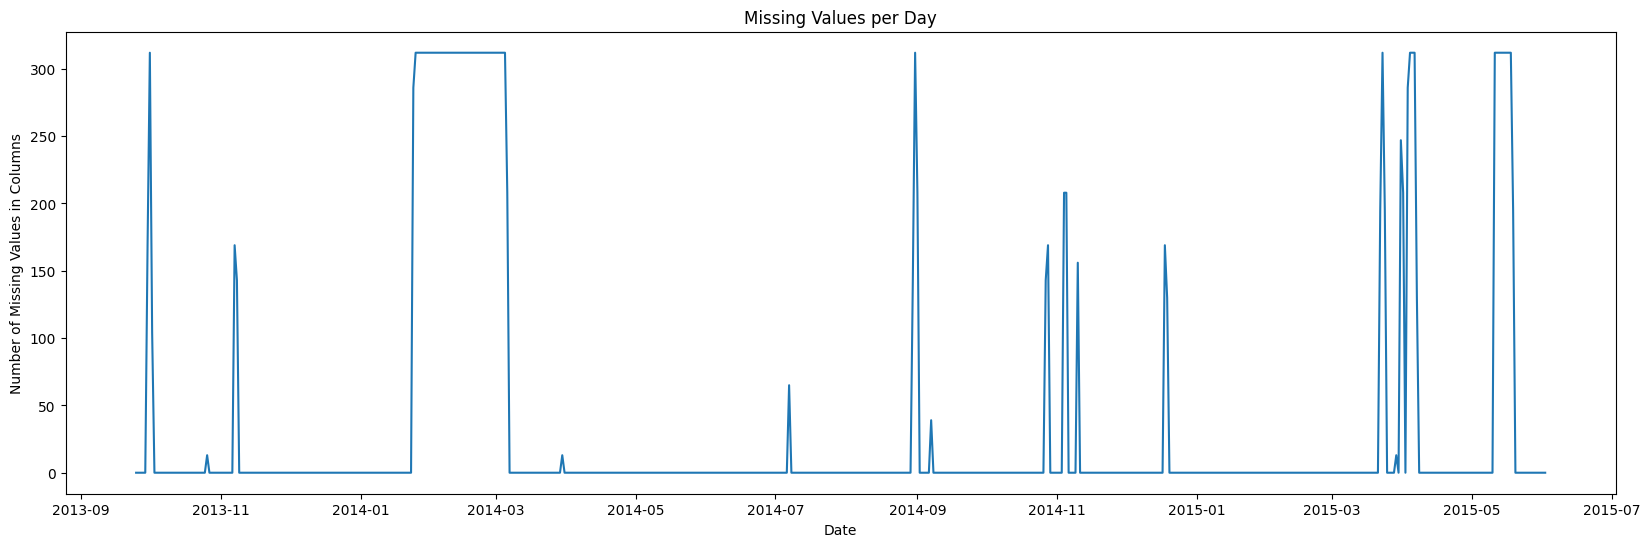

In [11]:
# Plot NAs count per day over the whole time range. Are there any evident missing periods?
# Hint: use isna(), groupby(), index.date and sum()

missing_values_per_day = df_merged.isna().groupby(df_merged.index.date).sum()

# sum total missing values
missing = missing_values_per_day.sum(axis=1, numeric_only=True)

# Plotting
plt.figure(figsize=(20, 6))
missing.plot()
plt.title('Missing Values per Day')
plt.xlabel('Date')
plt.ylabel('Number of Missing Values in Columns')
plt.show()

We can see the missing periods where there are peaks in the graph

In [12]:
# In 1 year, from 2014-03-10 to 2015-03-09, which appliance cumulatively consumed the most energy?

appliances = ['Toaster', 'Fridge-Freezer', 'Freezer',
              'Tumble Dryer', 'Dishwasher', 'Washing Machine',
              'Television', 'Microwave', 'Kettle']

# filter time and sum
one_year = df_merged[(df_merged.index >= '2014-03-10 00:00:00') & (df_merged.index <= '2015-03-09 23:00:00')]
one_year = one_year[appliances]
print(one_year.shape)
one_year

(8760, 9)


,Toaster,Fridge-Freezer,Freezer,Tumble Dryer,Dishwasher,Washing Machine,Television,Microwave,Kettle
Time,,,,,,,,,
2014-03-10 00:00:00,0.0,51.895000,27.340000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2014-03-10 01:00:00,0.0,12.646667,36.665000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2014-03-10 02:00:00,0.0,53.413333,41.070000,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2014-03-10 03:00:00,0.0,11.055092,26.889816,0.000000,0.0,0.000000,0.000000,0.0,0.000000
2014-03-10 04:00:00,0.0,47.402010,34.331658,0.000000,0.0,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
2015-03-09 19:00:00,0.0,92.011342,35.954631,0.000000,0.0,0.000000,143.826087,0.0,117.982987
2015-03-09 20:00:00,0.0,12.016981,26.015094,0.000000,0.0,0.000000,143.400000,0.0,0.000000
2015-03-09 21:00:00,0.0,46.518727,28.857678,940.612360,0.0,188.295880,143.574906,0.0,0.000000


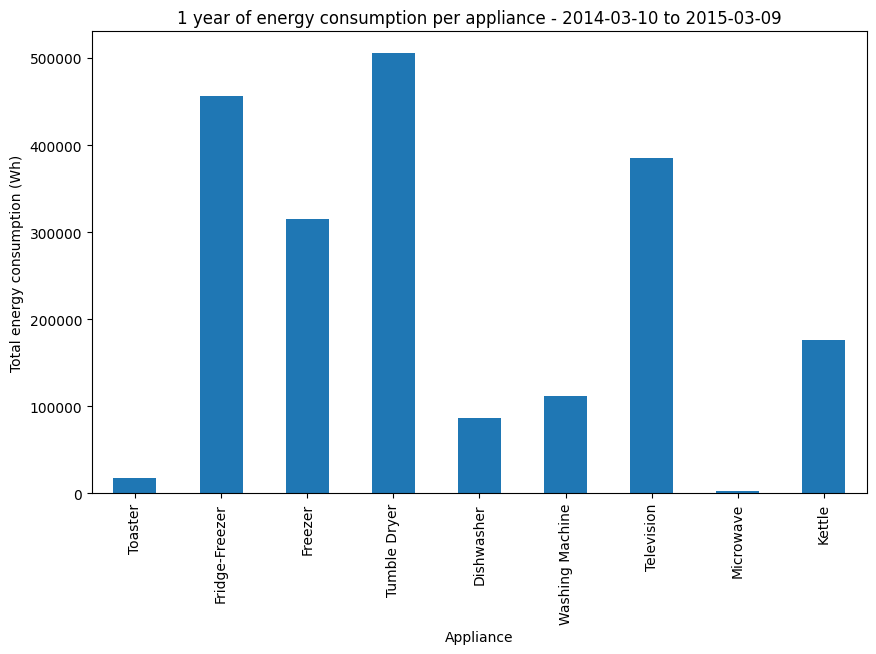

In [13]:
consumption = one_year.sum()

# plot
plt.figure(figsize=(10, 6))
consumption.plot(kind='bar')
plt.title('1 year of energy consumption per appliance - 2014-03-10 to 2015-03-09')
plt.xlabel('Appliance')
plt.ylabel('Total energy consumption (Wh)')
plt.show()

Tumble Dryer consumed the most energy.

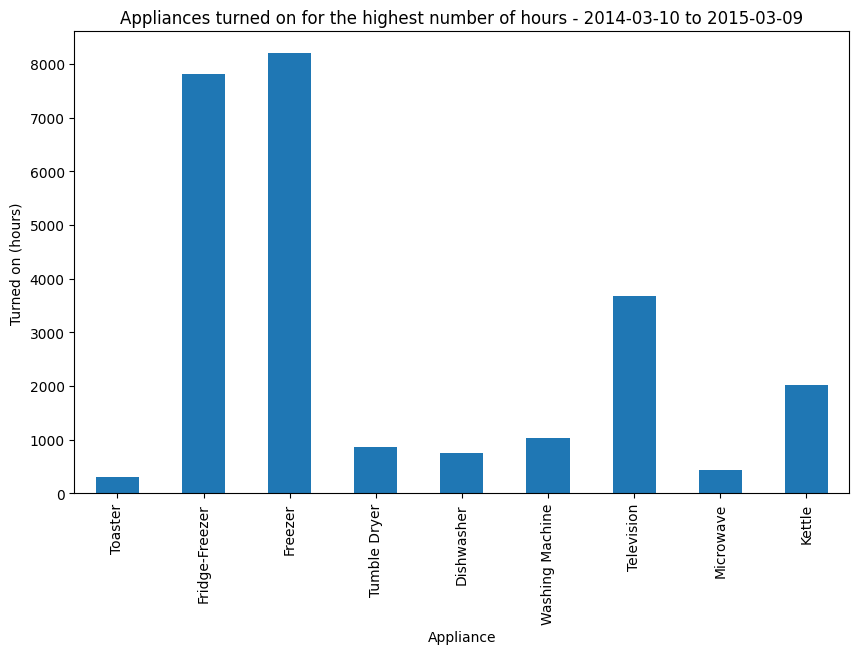

In [14]:
# Which appliance was turned on for the highest number of hours (i.e. consumption > 1Wh)?

# filter all rows
num_of_hrs = one_year > 1
num_of_hrs = num_of_hrs.sum()

plt.figure(figsize=(10, 6))
num_of_hrs.plot(kind='bar')
plt.title('Appliances turned on for the highest number of hours - 2014-03-10 to 2015-03-09')
plt.xlabel('Appliance')
plt.ylabel('Turned on (hours)')
plt.show()

Freezer was turned on for the highest number of hours.

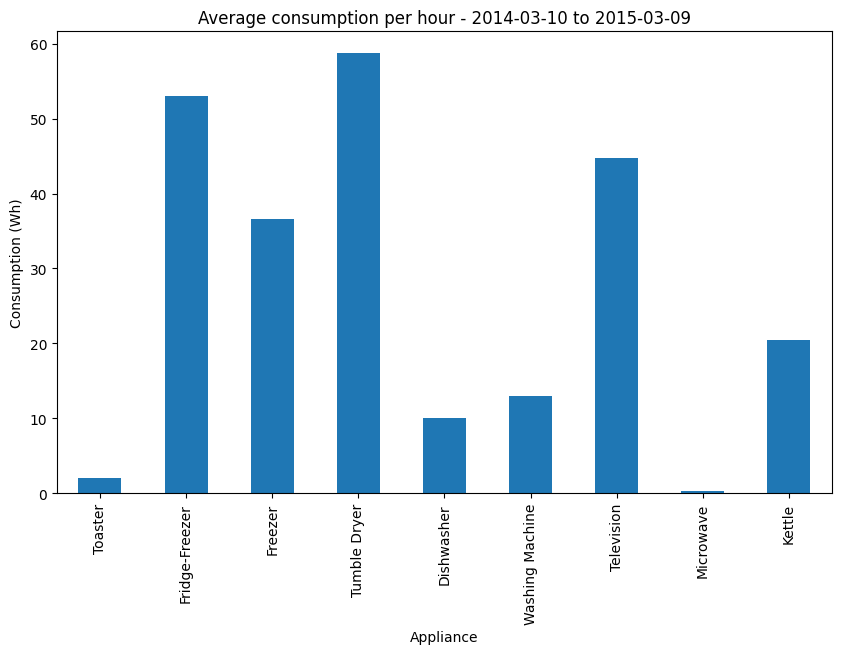

In [15]:
# Which appliance consumes per hour the highest?
average_per_hour = one_year.mean()

plt.figure(figsize=(10, 6))
average_per_hour.plot(kind='bar')
plt.title('Average consumption per hour - 2014-03-10 to 2015-03-09')
plt.xlabel('Appliance')
plt.ylabel('Consumption (Wh)')
plt.show()

In [16]:
# find out the highest consumption per each hour
fraction_df = one_year.groupby(one_year.index.time).sum()
highest_per_hr = fraction_df.idxmax(axis=1)
highest_per_hr

00:00:00    Fridge-Freezer
01:00:00    Fridge-Freezer
02:00:00    Fridge-Freezer
03:00:00    Fridge-Freezer
04:00:00    Fridge-Freezer
05:00:00    Fridge-Freezer
06:00:00    Fridge-Freezer
07:00:00      Tumble Dryer
08:00:00      Tumble Dryer
09:00:00      Tumble Dryer
10:00:00      Tumble Dryer
11:00:00      Tumble Dryer
12:00:00      Tumble Dryer
13:00:00      Tumble Dryer
14:00:00      Tumble Dryer
15:00:00      Tumble Dryer
16:00:00      Tumble Dryer
17:00:00      Tumble Dryer
18:00:00        Television
19:00:00        Television
20:00:00        Television
21:00:00        Television
22:00:00    Fridge-Freezer
23:00:00    Fridge-Freezer
dtype: object

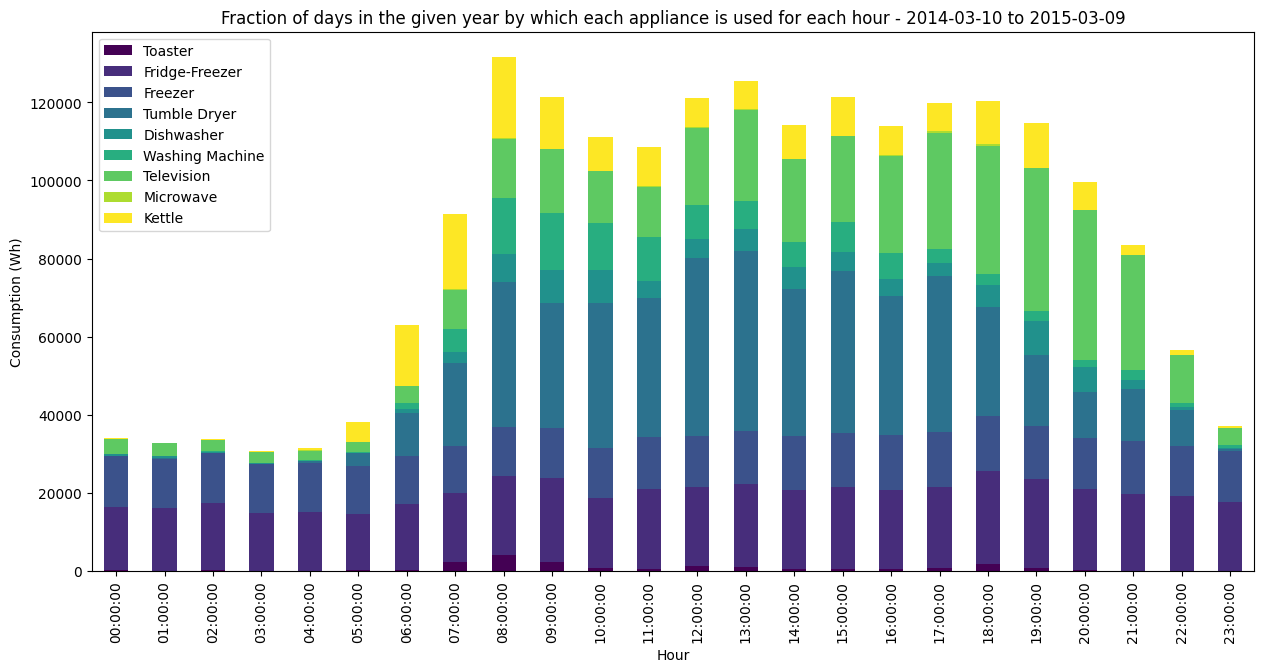

In [17]:
# Plot the fraction of days (y-axis) in the given year by which each appliance (color) is used for each hour (x-axis)

fraction_df = one_year.groupby(one_year.index.time).sum()

fig, ax = plt.subplots(figsize=(15, 7))
fraction_df.plot(kind='bar', stacked=True, colormap='viridis', ax=ax)
plt.title('Fraction of days in the given year by which each appliance is used for each hour - 2014-03-10 to 2015-03-09')
plt.xlabel('Hour')
plt.ylabel('Consumption (Wh)')
plt.show()

### Model training

In [44]:
# Prepare train and test datasets with the following characteristics:
# Train data period: from 2014-03-10 to 2015-03-09
# Test data period: 2015-03-10
# y feature: usage of television (i.e. consumption > 1)
# X features:
# - hour (int)
# - weekday (int)
# - weather variables
# - usage 24h before (1 if television was used at the same hour the day before)
# - activity 24h before (1 if any appliance was used at the same hour the day before)
# - usage yesterday (1 if television was used at least 1 hour during the whole day before)
# - price
# Drop NAs

# Hint for computing "usage yesterday": group usage by date, take the max, shift, then reindex to hourly using forward fill

X_features = ['Hour', 'Weekday'] + list(weather.columns.values) + ['Television_Usage_Before', 'Activity_Before', 'Usage_Yesterday'] + ['price']

# get hour and weekday cols
df_merged['Hour'] = df_merged.index.hour
df_merged['Weekday'] = df_merged.index.weekday

# usage 24h before (1 if television was used at the same hour the day before)
df_merged['Television_Usage_Before'] = (df_merged['Television'].shift(24) > 1).astype(int)

# activity 24h before (1 if any appliance was used at the same hour the day before)
activity_before = df_merged.shift(24) > 1
# check if any appliance was used
activity_before = activity_before[appliances]
activity_before = [int(any(row.values)) for i, row in activity_before.iterrows()]
df_merged['Activity_Before'] = activity_before

# usage yesterday (1 if television was used at least 1 hour during the whole day before)
usage_yesterday = df_merged['Television'].shift(24) # shift
usage_yesterday = usage_yesterday.groupby(usage_yesterday.index.date).max() > 1 # if television was used
usage_yesterday = usage_yesterday.reindex(df_merged.index, method='ffill') # reindex
df_merged['Usage_Yesterday'] = usage_yesterday.astype(int)

# training data from 2014-03-10 to 2015-03-09
training_data = df_merged[(df_merged.index >= '2014-03-10 00:00:00') & (df_merged.index <= '2015-03-09 23:00:00')].reset_index()
training_data.drop(columns=['Time'], inplace=True)
# Drop NAs
training_data = training_data.dropna()
X_train = training_data[X_features]
Y_train = training_data['Television'] > 1
print("Training data:", X_train.shape, Y_train.shape)

# test data 2015-03-10
test_data = df_merged[(df_merged.index >= '2015-03-10 00:00:00') & (df_merged.index <= '2015-03-10 23:00:00')].reset_index()
test_data.drop(columns=['Time'], inplace=True)
X_test = test_data[X_features]
Y_test = test_data['Television'] > 1
print("Test data:", X_test.shape, Y_test.shape)
X_train.head()

Training data: (8609, 11) (8609,)
Test data: (24, 11) (24,)


,Hour,Weekday,dwpt,rhum,temp,wdir,wspd,Television_Usage_Before,Activity_Before,Usage_Yesterday,price
0,0,0,0.43750,0.440741,0.597222,0.600000,0.269737,0,1,1,34.89
1,1,0,0.37500,0.437037,0.736111,0.685714,0.293421,0,1,1,33.72
2,2,0,0.34375,0.440741,0.819444,0.685714,0.194737,0,1,1,32.48
3,3,0,0.31250,0.403704,0.819444,0.714286,0.171053,0,1,1,32.47
4,4,0,0.34375,0.440741,0.819444,0.771429,0.242105,0,1,1,33.10


In [19]:
# Train a Random Forest Classifier according to the directions given above.

rfc = RandomForestClassifier(n_estimators=30, max_depth=20, random_state=42)

rfc.fit(X_train, Y_train)

y_pred = rfc.predict(X_train)
accuracy = accuracy_score(Y_train, y_pred)
print("Train Accuracy:", accuracy)

y_pred = rfc.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
print("Test Accuracy:", accuracy)

Train Accuracy: 0.9948890695783482
Test Accuracy: 0.7916666666666666


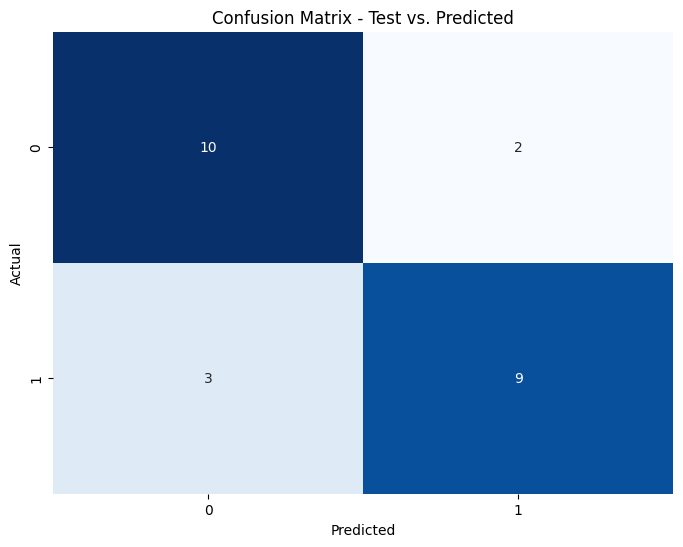

In [20]:
# Plot the test vs the predicted Usage
cm = confusion_matrix(Y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Test vs. Predicted')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Model explanation

In [21]:
# Compute the SHAP values for the 24 hours of the test dataset

import shap

explainer = shap.Explainer(rfc.predict, X_train)
shap_values = explainer(X_test)

PermutationExplainer explainer: 25it [00:10,  3.52s/it]


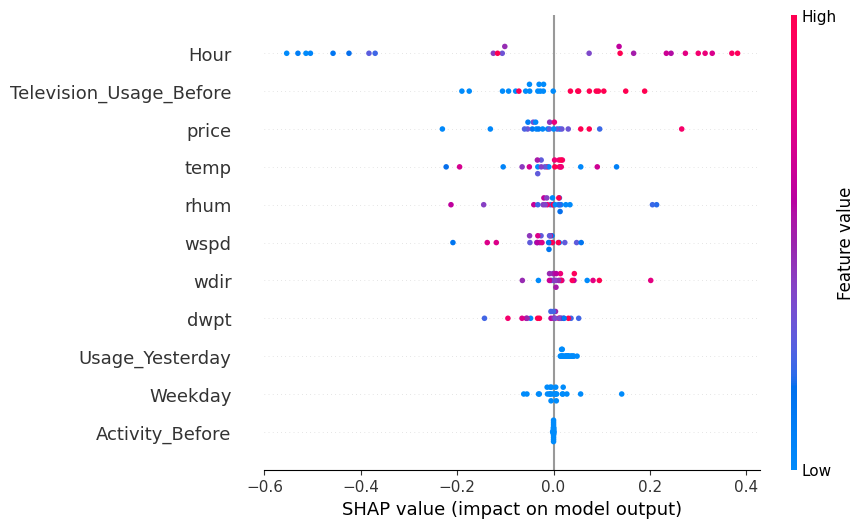

In [22]:
# Plot the SHAP values for each feature and test sample
shap.plots.beeswarm(shap_values, max_display=50)

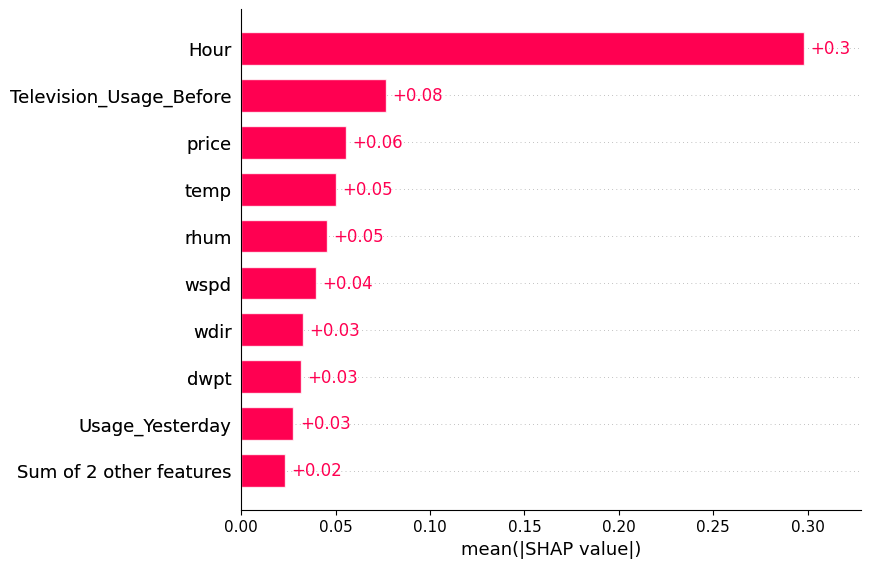

In [23]:
# What are the 3 most predictive features?
shap.plots.bar(shap_values)

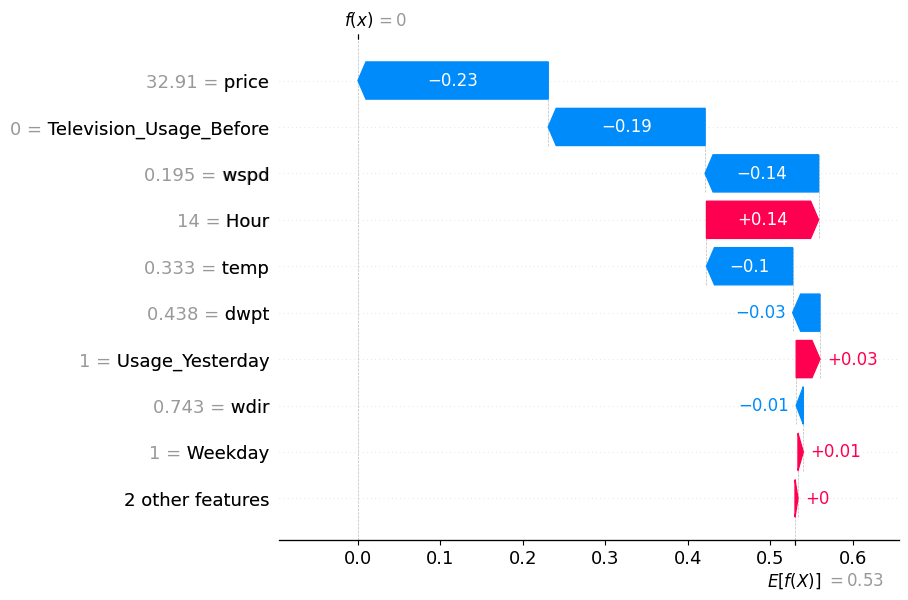

In [26]:
# Explain the 14:00 and 20:00 prediction of the test day. How could you interpret the difference?
shap.plots.waterfall(shap_values[14])

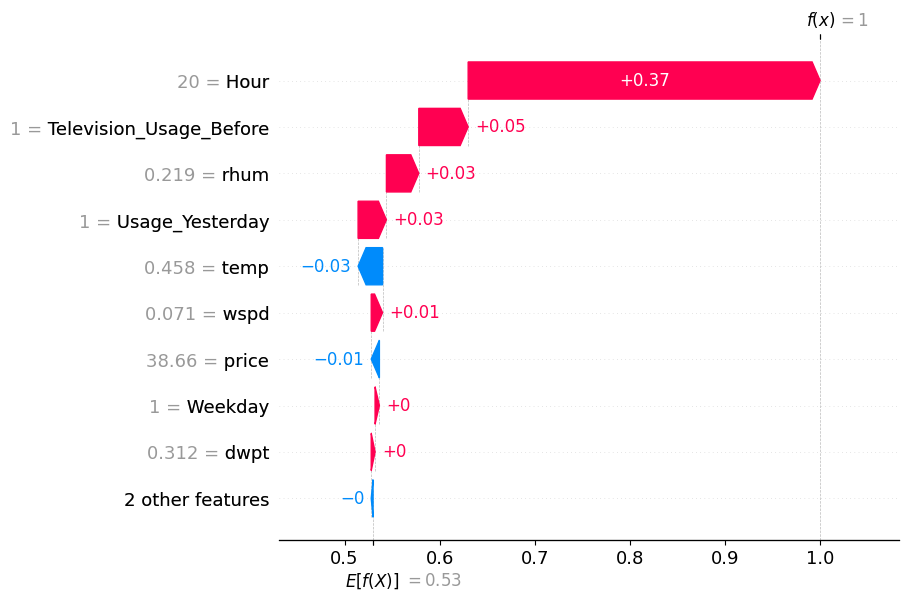

In [27]:
shap.plots.waterfall(shap_values[20])

- In general, hour (habit) and the television usage yesterday has a high correlation with consumption.
- In the afternoon, price and weather variables have a major influence on television consumption
- In the evening, less influence of the weather variables, weekday and price on the consumption and are more habit based (hour and television usage yesterday)

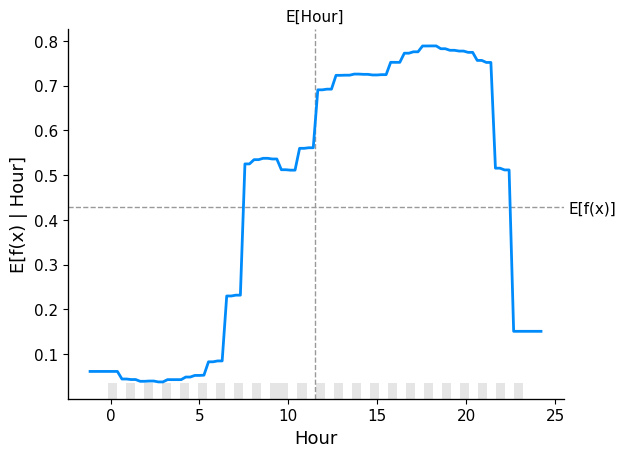

In [29]:
# In what hours is the expected probability of watching television highest, across the train dataset?

fig, ax = shap.partial_dependence_plot(
    "Hour",
    rfc.predict,
    X_train,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
)

Seems like the expected probabilty of watching television is highest around 18:00-19:00

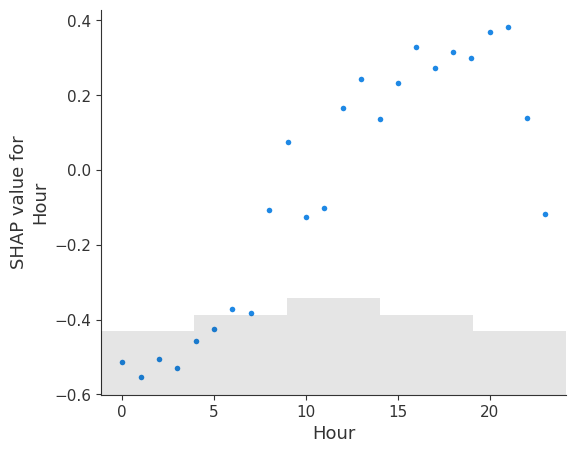

In [42]:
# Compare the partial dependence plot of expected probability of watching television (y-axis) by hour (x-axis) with
# a scatter plot of SHAP values (y-axis) for the 24 hours test samples, by hour (x-axis).
# Comment on their similarity/difference.

# Hint: use shap.plots.scatter for the latter

shap.plots.scatter(
    shap_values[:, "Hour"],
    cmap=plt.get_cmap("cool")
)

- Both graphs peak at the same period (evening)
- The partial dependence plot peaks at 18-19 while the scatter plot peaks at 20-21
- Both have a big drop after that

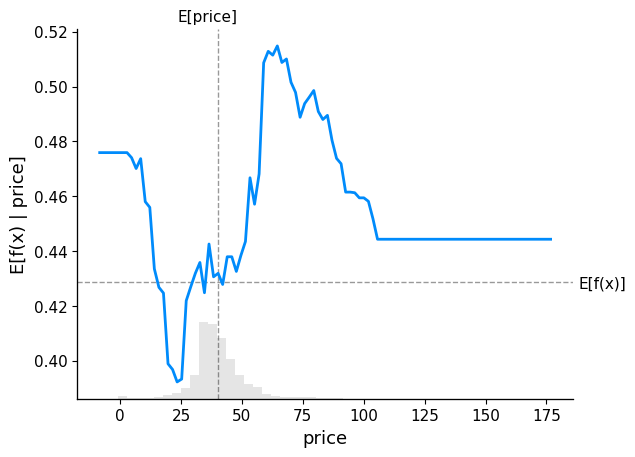

In [41]:
# What is the expected probability of watching television given the electricity price throughout the train dataset?
# How could one interpret this relationship?

fig, ax = shap.partial_dependence_plot(
    "price",
    rfc.predict,
    X_train,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
)

- As we saw before, the price has affect on the consumption only in the afternoon.
- We can see that even if the price is low, the prob. of watching televsion might decrease due to the hours (afternoon)
- And when the price is high, the prob. of television consumption might be high (evening)

### Reflections

**What strategies could you use to improve the accuracy of predicting TV usage? What are the implications for interpretability?**

*Strategies*
- Use additional lags other than 24 hours (e.g. 48, 72 hrs)
- Extract additional relevent temporal features such as holidays or special events that may influece the television usage patterns.
- Experiment with different algorithms and classfier models.
- Consider other ensemble methods, for example, Gradient Boosting.
- Fine-tune hyperparameters using techniques like grid-search.

*Implications for interpretability*
- As we introduce more features and potentially more complex models, interpretability may decrease. We need to keep a balance.
- Feature importance analysis can help understand the contribution of different features to predictions.
- Documentation is critical. Clearly document the features, preprocessing steps, and model choices to facilitate understanding and trust in the model.
- Communicate the model's predictions and limitations transparently to stakeholders, especially if the model is used in a decision-making context.


**What could be the benefits to a user of a XAI-informed model for predicting appliances usage? What could be the risks?**

*Benefits*
- *Transparency:* XAI provides transparency into the model's decision-making process. Users can better understand why the model makes specific predictions, enhancing trust.
- *Insights for improvement:* Explainable models can offer insights into which features are most influential in predictions. This information can guide users in refining the model or improving the quality of input features.
- *Trust:* Users are more likely to trust a model when they can interpret its decisions. This enhanced trust can lead to better user adoption and acceptance of the model's recommendations.
- *Biases:* XAI tools can help identify and address biases in the model, allowing users to understand if predictions are influenced by unfair or discriminatory patterns in the data.

*Risks*
- As models become more interpretable, there might be a trade-off with model complexity and predictive accuracy. Simplifying the model for interpretability may reduce its overall performance.
- Users may misinterpret or overinterpret explanations, especially if they lack a strong understanding of the underlying statistical concepts.